# Housing Prices Regression

Given over 1400 entries and 79 explanitory variables describing (almost) every aspect of residential homes in Ames, Iowa, the goal is predict the SalePrice label as closely as possible. Find this challenge on [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview).

## I. Imports

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

raw_data = pd.read_csv('train.csv')
raw_data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


## II. Data Cleaning

### A. Numerical Features

In [72]:
num_cols = list(raw_data.select_dtypes(['int64', 'float64']).columns)
num_cols.remove('MSSubClass')

complete_num_cols = [x for x in num_cols if len(raw_data[x])==len(raw_data[x].dropna())]
incomplete_num_cols = [x for x in num_cols if x not in complete_num_cols]
print('There are missing values in the following columns:', incomplete_num_cols)

There are missing values in the following columns: ['LotFrontage', 'MasVnrArea', 'GarageYrBlt']


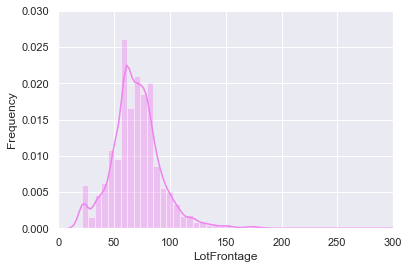

In [73]:
sns.set(style='darkgrid', palette=sns.diverging_palette(145, 280, s=85, l=25, n=7))
sns.distplot(raw_data['LotFrontage'].dropna(), color='violet')
plt.xlim(0, 300), plt.ylim(0, 0.030), plt.ylabel('Frequency')
plt.show()

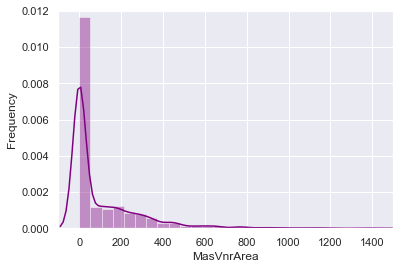

In [74]:
sns.distplot(raw_data['MasVnrArea'].dropna(), bins=30, color='purple')
plt.xlim(-100, 1500), plt.ylim(0, 0.012), plt.ylabel('Frequency')
plt.show()

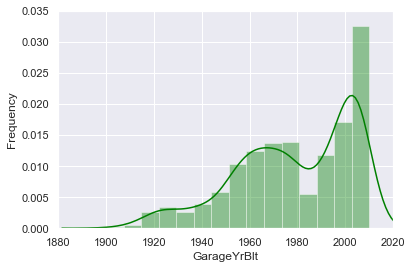

In [75]:
sns.distplot(raw_data['GarageYrBlt'].dropna(), color='green')
plt.xlim(1880, 2020), plt.ylim(0, 0.035), plt.ylabel('Frequency')
plt.show()

In [76]:
impute_filled = pd.DataFrame()
impute_filled['LotFrontage'] = raw_data.copy()['LotFrontage'].fillna(raw_data.copy()['LotFrontage'].mean())
impute_filled['MasVnrArea'] = raw_data.copy()['MasVnrArea'].fillna(raw_data.copy()['MasVnrArea'].median())
impute_filled['GarageYrBlt'] = raw_data.copy()['GarageYrBlt'].fillna(raw_data.copy()['GarageYrBlt'].mean())

num_data = pd.concat([raw_data[complete_num_cols].copy(), impute_filled], axis=1)

if len(num_data) == len(num_data.dropna()):
    print('Numerical data has been cleaned.')

Numerical data has been cleaned.


### B. Categorical Features

In [77]:
cat_cols = list(raw_data.select_dtypes(['object']).columns)
cat_cols.append('MSSubClass')

#### 1. Applying an Ordinal Scale

From the data_descriptions.txt file, I was able to find a number of categorical variables with discrete, state- or quality-based string presentations that are ordinal in nature. So, let's encode them!

In [78]:
ord_conforming_cols = ['Street', 'Alley', 'PavedDrive', 'GarageFinish', 'GarageQual', 'GarageCond',
                      'Utilities', 'LandSlope', 'Fence', 'ExterQual', 'ExterCond', 'PoolQC',
                       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                       'HeatingQC', 'CentralAir', 'KitchenQual', 'FireplaceQu']
if all([x for x in ord_conforming_cols if x in raw_data.columns]):
    print('All elements of ord_conforming_cols are spelled correctly and in the original data.')

non_quality_based_cols = ['Street', 'Alley', 'PavedDrive', 'GarageFinish', 'Utilities', 
                          'LandSlope', 'BsmtFinType1', 'BsmtFinType2', 'CentralAir', 'Fence']
quality_based_cols = [x for x in ord_conforming_cols if x not in non_quality_based_cols]
quality_based_cols

All elements of ord_conforming_cols are spelled correctly and in the original data.


['GarageQual',
 'GarageCond',
 'ExterQual',
 'ExterCond',
 'PoolQC',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'HeatingQC',
 'KitchenQual',
 'FireplaceQu']

In [79]:
standard_quality = {np.nan: 0, 'Po': 1, 'No': 1, 'Fa': 2, 'Mn': 2,'TA': 3, 'Av': 3, 'Gd': 4, 'Ex': 5}
fence_quality = {np.nan: 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4}
basement_finishing_states = {np.nan: 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}
garage_finishing_states = {np.nan: 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}
slope_quality = {'Gtl': 1, 'Mod': 2, 'Sev': 3}
pavings = {np.nan: 0, 'N': 0, 'P': 1, 'Grvl': 1, 'Y': 2, 'Pave': 2}
utils = {'ELO': 1, 'NoSeWa': 2, 'NoSewr': 3, 'AllPub': 4}
bls = {'N': 0, 'Y': 1}

ordinal_df = pd.DataFrame()

for x in quality_based_cols:
    ordinal_df[x] = raw_data[x].copy().apply(lambda x: standard_quality[x])
for x in ['Street', 'Alley', 'PavedDrive']:
    ordinal_df[x] = raw_data[x].copy().apply(lambda x: pavings[x])
for x in ['BsmtFinType1', 'BsmtFinType2']:
    ordinal_df[x] = raw_data[x].copy().apply(lambda x: basement_finishing_states[x])

ordinal_df['Utilities'] = raw_data['Utilities'].copy().apply(lambda x: utils[x])
ordinal_df['LandSlope'] = raw_data['LandSlope'].copy().apply(lambda x: slope_quality[x])
ordinal_df['GarageFinish'] = raw_data['GarageFinish'].copy().apply(lambda x: garage_finishing_states[x])
ordinal_df['CentralAir'] = raw_data['CentralAir'].copy().apply(lambda x: bls[x])
ordinal_df['Fence'] = raw_data['Fence'].copy().apply(lambda x: fence_quality[x])

ordinal_df

,GarageQual,GarageCond,ExterQual,ExterCond,PoolQC,BsmtQual,BsmtCond,BsmtExposure,HeatingQC,KitchenQual,...,Street,Alley,PavedDrive,BsmtFinType1,BsmtFinType2,Utilities,LandSlope,GarageFinish,CentralAir,Fence
0,3,3,4,3,0,4,3,1,5,4,...,2,0,2,6,1,4,1,2,1,0
1,3,3,3,3,0,4,3,4,5,3,...,2,0,2,5,1,4,1,2,1,0
2,3,3,4,3,0,4,3,2,5,4,...,2,0,2,6,1,4,1,2,1,0
3,3,3,3,3,0,3,4,1,4,4,...,2,0,2,5,1,4,1,1,1,0
4,3,3,4,3,0,4,3,3,5,4,...,2,0,2,6,1,4,1,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,3,3,3,3,0,4,3,1,5,3,...,2,0,2,1,1,4,1,2,1,0
1456,3,3,3,3,0,4,3,1,3,3,...,2,0,2,5,3,4,1,1,1,3
1457,3,3,5,4,0,3,4,1,5,4,...,2,0,2,6,1,4,1,2,1,4
1458,3,3,3,3,0,3,3,2,4,4,...,2,0,2,6,3,4,1,1,1,0


In [80]:
if len(ordinal_df.dropna()) == len(ordinal_df):
    print('Ordinal data has been preserved.')

Ordinal data has been preserved.


#### 2. Nominal Features

The MSSubClass categorical variable has numerical encodings. After looking at data_description.txt, its clear that these values are non-uniformily distributed and completly arbitrary. So, let's just encode them as strs. We also should make a df of nominal features.

In [81]:
nominal_cat_cols = [x for x in cat_cols if x not in ord_conforming_cols]
nominal_df = raw_data[nominal_cat_cols].copy()
dwelling_types = {20: '1F_Y>=1946', 30: '1F_Y<=1945', 40: '1F_Finished Attic',
                  45: '1.5F_Y>=1946 Unfinished', 50: '1.5F_Finished', 60: '2F_Y>=1946',
                  70: '2F_Y<=1945', 75: '2.5F', 80: 'Split/Multilevel',
                  85: 'SplitFoyer', 90: 'Duplex', 120: '1F_PUD(Y>=1946)',
                  150: '1.5F_PUD', 160: '2F_PUD(Y>=1946)', 180: 'Split/Multilevel_PUD',
                  190: '2FamConver'}
nominal_df['MSSubClass'] = raw_data['MSSubClass'].copy().apply(lambda x: dwelling_types[x])
nominal_df

,MSZoning,LotShape,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,...,MasVnrType,Foundation,Heating,Electrical,Functional,GarageType,MiscFeature,SaleType,SaleCondition,MSSubClass
0,RL,Reg,Lvl,Inside,CollgCr,Norm,Norm,1Fam,2Story,Gable,...,BrkFace,PConc,GasA,SBrkr,Typ,Attchd,NaN,WD,Normal,2F_Y>=1946
1,RL,Reg,Lvl,FR2,Veenker,Feedr,Norm,1Fam,1Story,Gable,...,None,CBlock,GasA,SBrkr,Typ,Attchd,NaN,WD,Normal,1F_Y>=1946
2,RL,IR1,Lvl,Inside,CollgCr,Norm,Norm,1Fam,2Story,Gable,...,BrkFace,PConc,GasA,SBrkr,Typ,Attchd,NaN,WD,Normal,2F_Y>=1946
3,RL,IR1,Lvl,Corner,Crawfor,Norm,Norm,1Fam,2Story,Gable,...,None,BrkTil,GasA,SBrkr,Typ,Detchd,NaN,WD,Abnorml,2F_Y<=1945
4,RL,IR1,Lvl,FR2,NoRidge,Norm,Norm,1Fam,2Story,Gable,...,BrkFace,PConc,GasA,SBrkr,Typ,Attchd,NaN,WD,Normal,2F_Y>=1946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Reg,Lvl,Inside,Gilbert,Norm,Norm,1Fam,2Story,Gable,...,None,PConc,GasA,SBrkr,Typ,Attchd,NaN,WD,Normal,2F_Y>=1946
1456,RL,Reg,Lvl,Inside,NWAmes,Norm,Norm,1Fam,1Story,Gable,...,Stone,CBlock,GasA,SBrkr,Min1,Attchd,NaN,WD,Normal,1F_Y>=1946
1457,RL,Reg,Lvl,Inside,Crawfor,Norm,Norm,1Fam,2Story,Gable,...,None,Stone,GasA,SBrkr,Typ,Attchd,Shed,WD,Normal,2F_Y<=1945
1458,RL,Reg,Lvl,Inside,NAmes,Norm,Norm,1Fam,1Story,Hip,...,None,CBlock,GasA,FuseA,Typ,Attchd,NaN,WD,Normal,1F_Y>=1946


In [82]:
if (len(nominal_cat_cols) + len(ordinal_df.columns) == len(cat_cols)):
    print('Categorical columns have been preserved.')

Categorical columns have been preserved.


### C. Putting it All Together

In [83]:
dummy_df = pd.get_dummies(nominal_df)
df = pd.concat([num_data, ordinal_df, dummy_df], axis=1).drop('Id', axis=1)

if len(df) == len(df.dropna()):
    print('No NaN values are left, and the data has been cleaned.')
df

No NaN values are left, and the data has been cleaned.


,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,MSSubClass_1F_Y>=1946,MSSubClass_2.5F,MSSubClass_2F_PUD(Y>=1946),MSSubClass_2F_Y<=1945,MSSubClass_2F_Y>=1946,MSSubClass_2FamConver,MSSubClass_Duplex,MSSubClass_Split/Multilevel,MSSubClass_Split/Multilevel_PUD,MSSubClass_SplitFoyer
0,8450,7,5,2003,2003,706,0,150,856,856,...,0,0,0,0,1,0,0,0,0,0
1,9600,6,8,1976,1976,978,0,284,1262,1262,...,1,0,0,0,0,0,0,0,0,0
2,11250,7,5,2001,2002,486,0,434,920,920,...,0,0,0,0,1,0,0,0,0,0
3,9550,7,5,1915,1970,216,0,540,756,961,...,0,0,0,1,0,0,0,0,0,0
4,14260,8,5,2000,2000,655,0,490,1145,1145,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,7917,6,5,1999,2000,0,0,953,953,953,...,0,0,0,0,1,0,0,0,0,0
1456,13175,6,6,1978,1988,790,163,589,1542,2073,...,1,0,0,0,0,0,0,0,0,0
1457,9042,7,9,1941,2006,275,0,877,1152,1188,...,0,0,0,1,0,0,0,0,0,0
1458,9717,5,6,1950,1996,49,1029,0,1078,1078,...,1,0,0,0,0,0,0,0,0,0


## III. EDA & DataViz

### A. The SalePrice Label

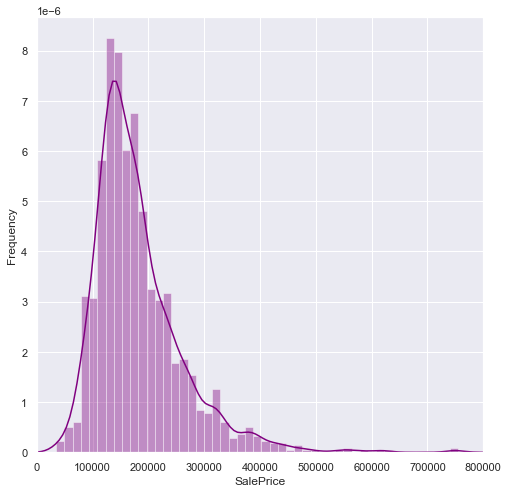

In [84]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.distplot(df['SalePrice'], ax=ax, color='purple')
plt.xlim(0, 800000), plt.ylabel('Frequency')
plt.show()

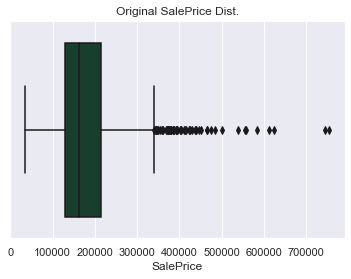

In [85]:
sns.boxplot(df['SalePrice'])
plt.title('Original SalePrice Dist.')
plt.show()

In [86]:
print('Originally, ')
print('\u03BC: {:,.3f}, \u03C3: {:,.3f}, skew {:,.3f}'.format(df['SalePrice'].mean(), df['SalePrice'].std(), df['SalePrice'].skew()))
print('Std to Mean Ratio: {:,.5f}'.format((df['SalePrice'].std()/df['SalePrice'].mean())))

Originally, 
μ: 180,921.196, σ: 79,442.503, skew 1.883
Std to Mean Ratio: 0.43910


Overall, the SalePrice label seems to follow a fairly Normal distribution, with some outliers. There is also considerable positive skew, which is to be expected. The main problem is that our variance and standard deviation are impractically large.
However, we should be able reduce this noise by imposing a $y_t = ln(y)$ transformation.

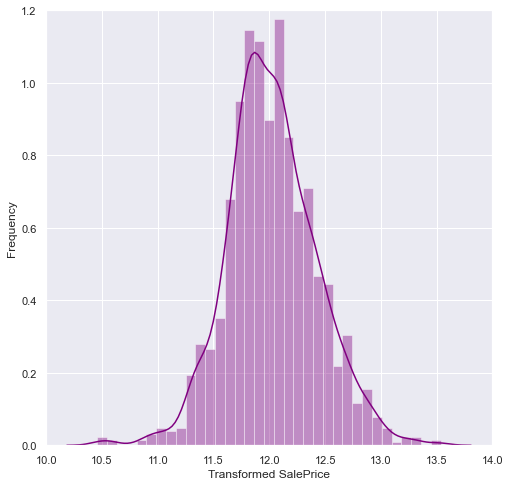

In [87]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.distplot(np.log(df['SalePrice']), ax=ax, color='purple', axlabel='Transformed SalePrice')
plt.xlim(10, 14), plt.ylim(0, 1.2), plt.ylabel('Frequency')
plt.show()

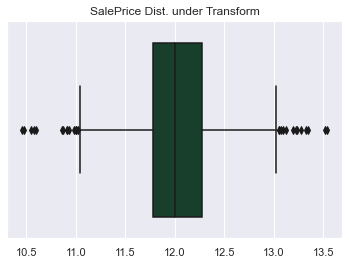

In [88]:
sp_t = np.log(df['SalePrice'])
sns.boxplot(sp_t.to_frame())
plt.title('SalePrice Dist. under Transform')
plt.show()

In [89]:
print('Under the transformation, ')
print('\u03BC: {:,.3f}, \u03C3: {:,.3f}, skew {:,.3f}'.format(sp_t.mean(), sp_t.std(), sp_t.skew()))
print('Std to Mean Ratio: {:,.5f}'.format((sp_t.std()/sp_t.mean())))

Under the transformation, 
μ: 12.024, σ: 0.399, skew 0.121
Std to Mean Ratio: 0.03322


The aforementioned transform seems pretty ideal since it groups the SalePrice closer to its mean, reducing variance and skew in the process.

### B. Feature Correlation

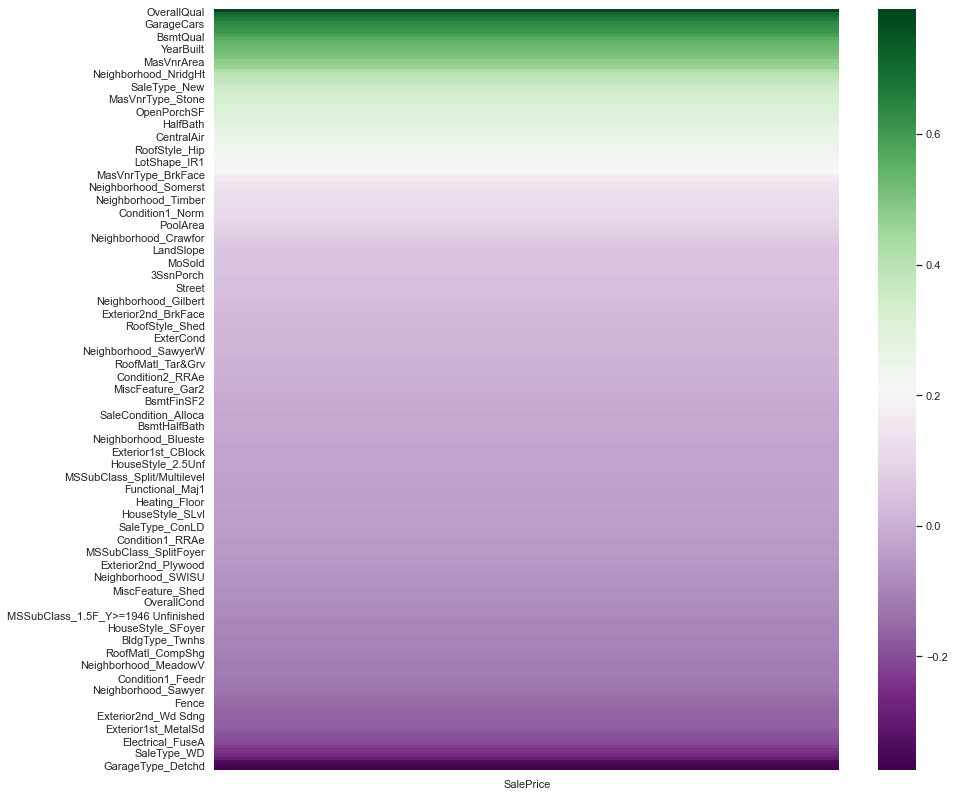

In [90]:
sales_correlations = df.corr()['SalePrice'].to_frame().sort_values(by='SalePrice', ascending=False)[1:]
fig, ax = plt.subplots(figsize=(14, 14))
sns.heatmap(data=sales_correlations, cmap='PRGn')
plt.show()

In [91]:
sales_correlations

,SalePrice
OverallQual,0.790982
GrLivArea,0.708624
ExterQual,0.682639
KitchenQual,0.659600
GarageCars,0.640409
...,...
LotShape_Reg,-0.267672
MSZoning_RM,-0.288065
Foundation_CBlock,-0.343263
GarageType_Detchd,-0.354141


The above graphic uses hue to represent the correlational array that relates all features to the SalePrice label. This is using the standard correlation coefficient. Independent variables that are more weakly correlated will appear towards the bottom, with stronger ones towards the top. <u>Practically, this means that no masonry vaneer, a detached garage, or cinder block foundation should contribute least value to a home's sale price.</u>

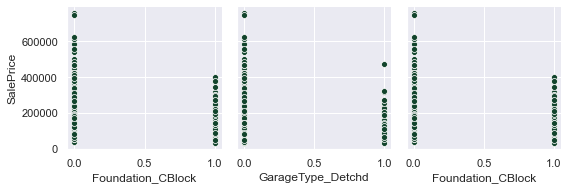

In [92]:
sns.pairplot(data=df, x_vars=['Foundation_CBlock', 'GarageType_Detchd', 'Foundation_CBlock'], y_vars=['SalePrice'])
plt.show()

In [93]:
sales_correlations[abs(sales_correlations['SalePrice']) > 0.5]

,SalePrice
OverallQual,0.790982
GrLivArea,0.708624
ExterQual,0.682639
KitchenQual,0.659600
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
BsmtQual,0.585207
FullBath,0.560664


### C. Potentially Redundant Features

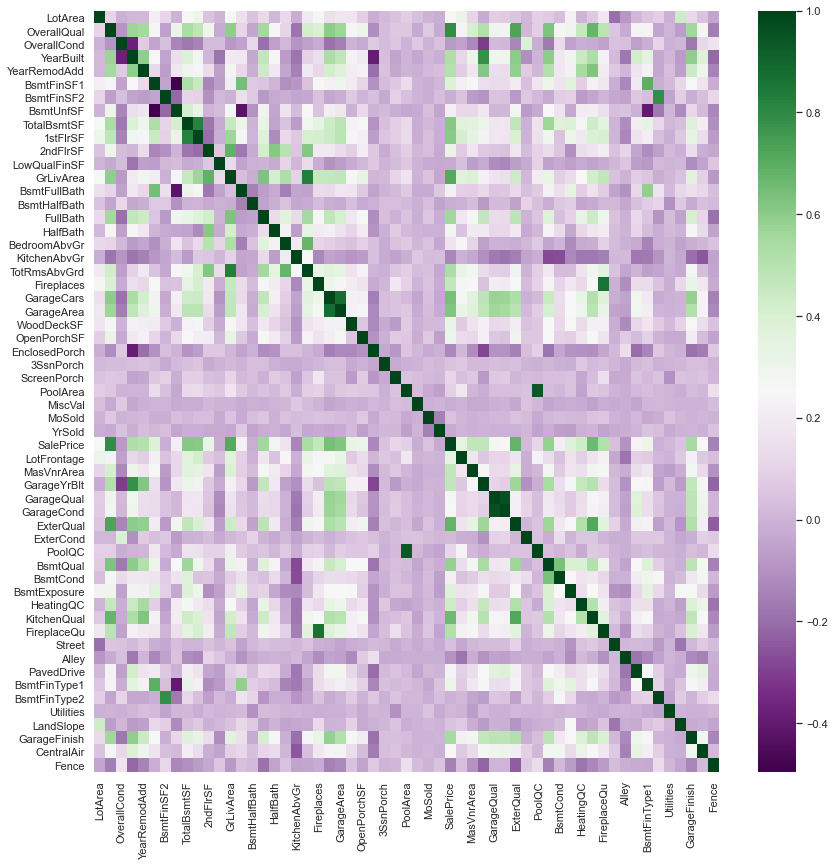

In [94]:
fig, ax = plt.subplots(figsize=(14, 14))
nonbin_corrs = df.select_dtypes(['int64', 'float64']).corr()
sns.heatmap(nonbin_corrs, cmap='PRGn', ax=ax)
plt.show()

After having examined the heatmap above, I've taken a note of some strongly correlated feature pairs:
* TotalBsmtSF, 1stFlrSF
* **GrLivArea, TotRmsAbvGr**
* Fireplaces, GrLivArea
* Fireplaces, FireplaceQu
* PoolArea, PoolQC
* **GarageQual, GarageCond**
* **GarageArea, GarageCars**
* GarageQual, ExterQual

The correlation coefficent between GarageQual and GarageCond is 0.9592


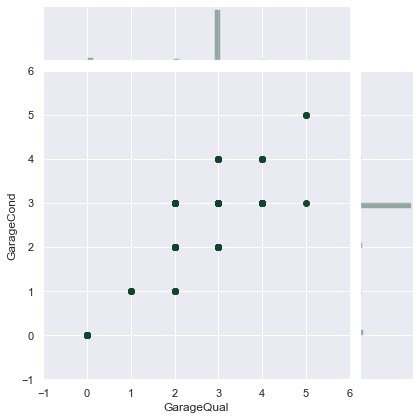

In [95]:
print('The correlation coefficent between GarageQual and GarageCond is {:.4f}'.format(nonbin_corrs['GarageQual']['GarageCond']))
sns.jointplot(x='GarageQual', y='GarageCond', data=df,
             xlim=[-1, 6], ylim=[-1, 6])
plt.show()

In [96]:
print('With respect to the SalePrice feature, correlation strength is:')
print('GarageQual: {:.3f}'.format(float(sales_correlations.T['GarageQual'])))
print('GarageCond: {:.3f}'.format(float(sales_correlations.T['GarageCond'])))

With respect to the SalePrice feature, correlation strength is:
GarageQual: 0.274
GarageCond: 0.263


The correlation coefficent between GarageArea and GarageCars is 0.8825


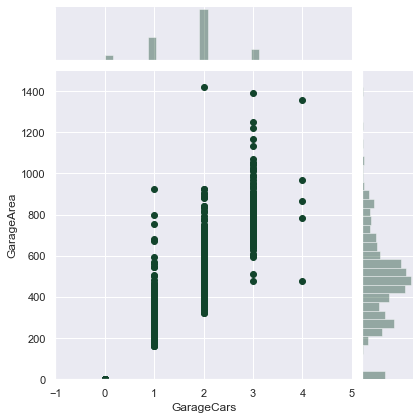

In [97]:
print('The correlation coefficent between GarageArea and GarageCars is {:.4f}'.format(nonbin_corrs['GarageArea']['GarageCars']))
sns.jointplot(x='GarageCars', y='GarageArea', data=df,
             xlim=[-1, 5], ylim=[0, 1500])
plt.show()

In [98]:
print('With respect to the SalePrice feature, correlation strength is:')
print('GarageCars: {:.3f}'.format(float(sales_correlations.T['GarageCars'])))
print('GarageArea: {:.3f}'.format(float(sales_correlations.T['GarageArea'])))

With respect to the SalePrice feature, correlation strength is:
GarageCars: 0.640
GarageArea: 0.623


The correlation coefficent between TotRmsAbvGr and GrLivArea is 0.8255


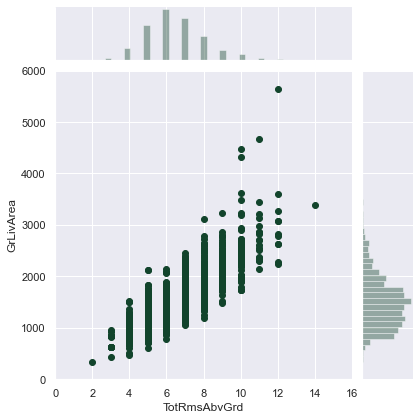

In [99]:
print('The correlation coefficent between TotRmsAbvGr and GrLivArea is {:.4f}'.format(nonbin_corrs['TotRmsAbvGrd']['GrLivArea']))
sns.jointplot(x='TotRmsAbvGrd', y='GrLivArea', data=df,
             xlim=[0, 16], ylim=[0, 6000])
plt.show()

In [100]:
print('With respect to the SalePrice feature, correlation strength is:')
print('TotRmsAbvGrd: {:.3f}'.format(float(sales_correlations.T['TotRmsAbvGrd'])))
print('GrLivArea: {:.3f}'.format(float(sales_correlations.T['GrLivArea'])))

With respect to the SalePrice feature, correlation strength is:
TotRmsAbvGrd: 0.534
GrLivArea: 0.709


We can potentially drop the GarageCond, GarageArea, and TotRmsAbvGrd features to alleviate potential multicollinearity. 

## IV. Regression Task

In [101]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [102]:
X0 = df.drop('SalePrice', axis=1)
y0 = np.log(df['SalePrice'])
X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y0, test_size=0.33, random_state=42)

Xa = df.drop(['SalePrice', 'GarageCond', 'GarageArea', 'TotRmsAbvGrd'], axis=1)
ya = np.log(df['SalePrice'])
Xa_train, Xa_test, ya_train, ya_test = train_test_split(Xa, ya, test_size=0.33, random_state=42)

### A. Linear Models

In [104]:
lm_0 = LinearRegression()
lm_0.fit(X0_train, y0_train)
lm_pred_t0 = lm_0.predict(X0_test)

lm_a = LinearRegression()
lm_a.fit(Xa_train, ya_train)
lm_pred_ta = lm_a.predict(Xa_test)

rr_0 = RidgeCV()
rr_0.fit(X0_train, y0_train)
rr_pred_t0 = rr_0.predict(X0_test)

rr_a = RidgeCV(alphas=[0.0001, 0.001, 0.01, 0.1, 1, 10])
rr_a.fit(Xa_train, ya_train)
rr_pred_ta = rr_a.predict(Xa_test)

In [105]:
linear_models_summary = pd.DataFrame.from_dict(data={'RMSE': [np.sqrt(mean_squared_error(y0_test, lm_pred_t0)), np.sqrt(mean_squared_error(ya_test, lm_pred_ta)), np.sqrt(mean_squared_error(y0_test, rr_pred_t0)), np.sqrt(mean_squared_error(ya_test, rr_pred_ta))],
'R2 score': [r2_score(y0_test, lm_pred_t0), r2_score(ya_test, lm_pred_ta), r2_score(y0_test, rr_pred_t0), r2_score(ya_test, rr_pred_ta)]})
linear_models_summary['model'] = ['LinearRegression (X0, y0)', 'LinearRegression (Xa, ya)', 'RidgeCV (X0, y0)', 'RidgeCV (Xa, ya)']
linear_models_summary.set_index('model', inplace=True)
linear_models_summary.sort_values(by='RMSE').round(decimals=4)

,RMSE,R2 score
model,,
"LinearRegression (Xa, ya)",0.1310,0.8993
"LinearRegression (X0, y0)",0.1313,0.8989
"RidgeCV (Xa, ya)",0.1357,0.8920
"RidgeCV (X0, y0)",0.1363,0.8909


### B. Ensemble Models

In [106]:
rfr = RandomForestRegressor(random_state=42)
rfr.fit(Xa_train, ya_train)
rfr_pred = rfr.predict(Xa_test)

gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(Xa_train, ya_train)
gbr_pred = gbr.predict(Xa_test)

In [107]:
ensemble_summary = pd.DataFrame.from_dict(data={'RMSE': [np.sqrt(mean_squared_error(y0_test, rfr_pred)), np.sqrt(mean_squared_error(y0_test, gbr_pred))], 'R2 score': [r2_score(y0_test, rfr_pred), r2_score(y0_test, gbr_pred)]})
ensemble_summary['model'] = ['RandomForestRegressor (Xa, ya)', 'GradientBoostingRegressor (Xa, ya)']
ensemble_summary.set_index('model', inplace=True)
ensemble_summary.sort_values(by='RMSE').round(decimals=4)

,RMSE,R2 score
model,,
"GradientBoostingRegressor (Xa, ya)",0.1407,0.8838
"RandomForestRegressor (Xa, ya)",0.1420,0.8817


In this particular instance, neither the application of L2-regularization, Random Forests nor Gradient Boosting offered any advantage over the naive OLS estimator. Moverover, we did see some improvement when using the (Xa, ya) dataset over the null (X0, y0) dataset, since collinear features were removed. This is beneficial, since our simple LinearRegression object is the least computationally involved.

## V. Linear Model Evaluation

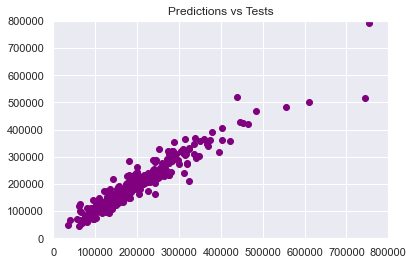

In [108]:
true_test, true_pred = np.exp(ya_test), np.exp(lm_pred_ta)
plt.scatter(true_test, true_pred, c='purple')
plt.title('Predictions vs Tests')
plt.xlim(0, 800000), plt.ylim(0, 800000)
plt.show() 

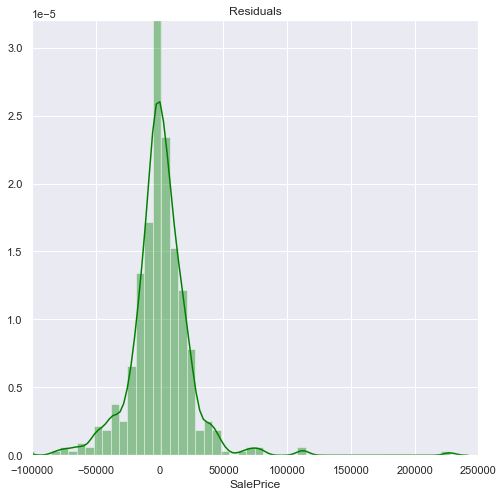

In [109]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.distplot((true_test-true_pred), bins=50, color='green', ax=ax)
plt.xlim(-100000, 250000), plt.ylim(0, 0.000032), plt.title('Residuals')
plt.show()

In [111]:
full_final_predictions = np.exp(lm_a.predict(Xa))